In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment import SentimentIntensityAnalyzer
from itertools import combinations
import seaborn as sns
import gender_guesser.detector as gender
from sklearn.metrics import silhouette_score
import umap

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
df = pd.read_parquet('../datasets/bechdel_ratings.parquet')
#df = df.rename(columns={'rating': 'bechdel_rating'})
df.to_parquet('../datasets/bechdel_ratings.parquet', index=False)

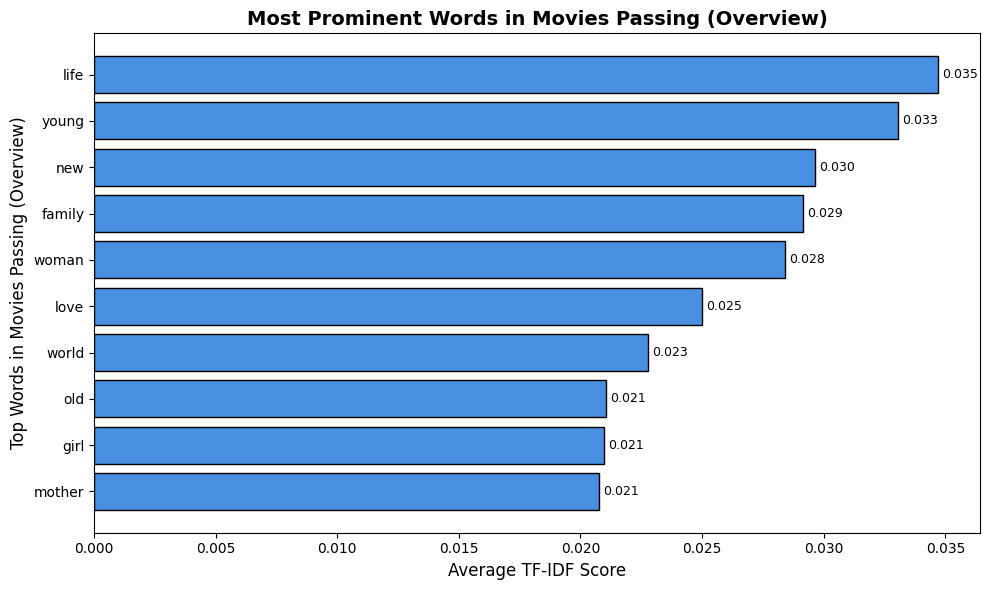

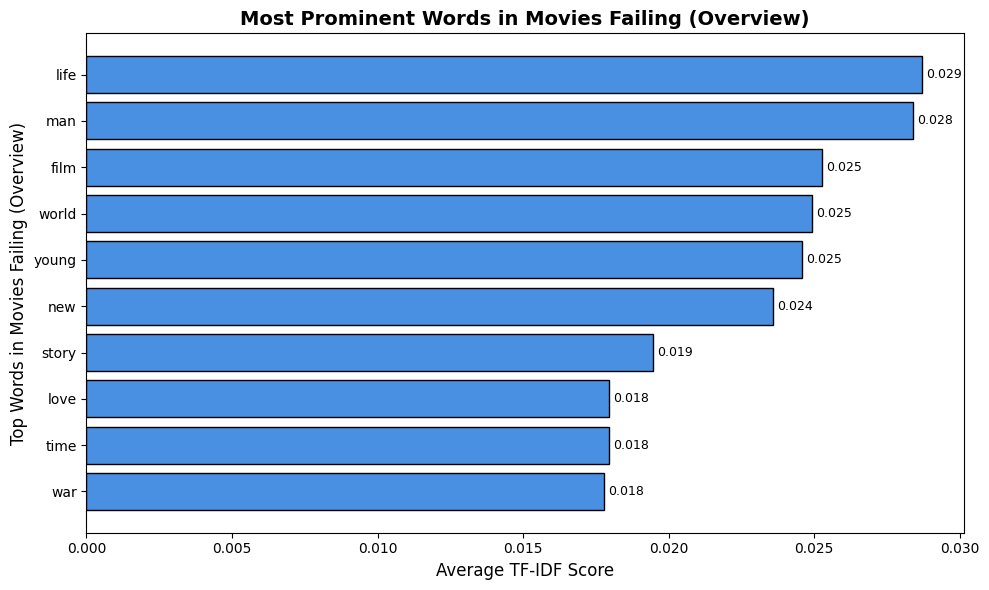

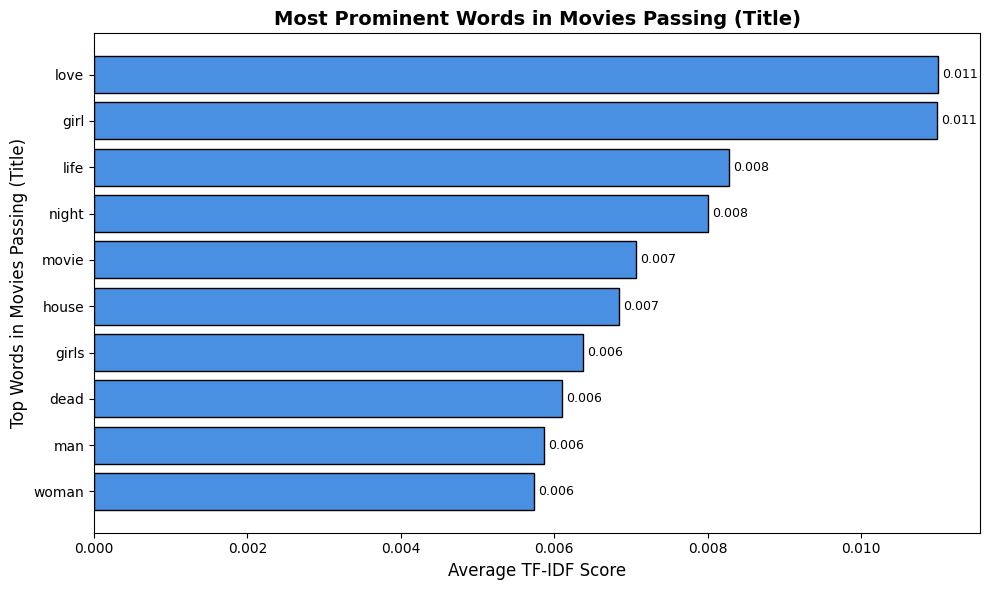

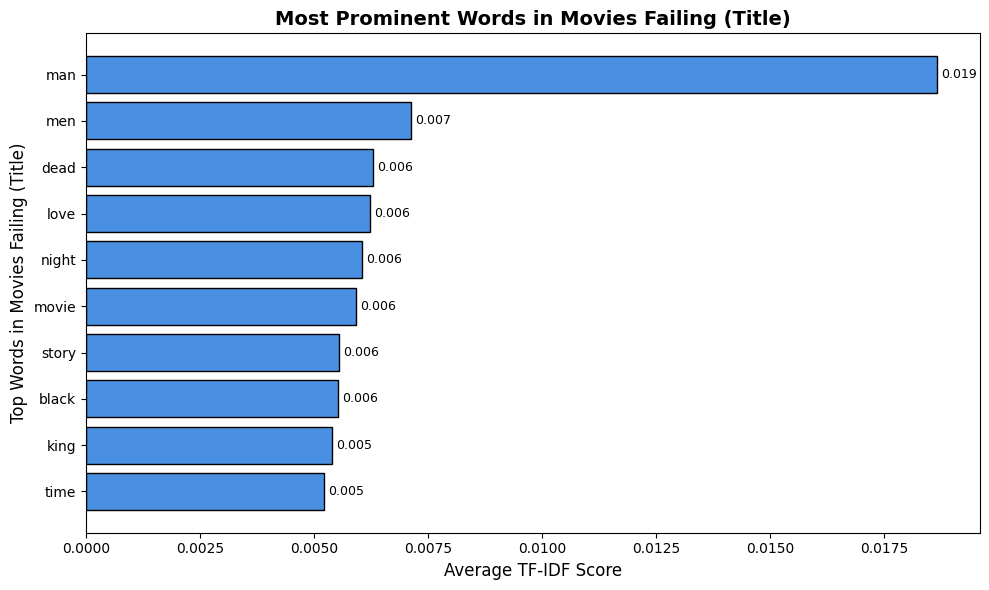

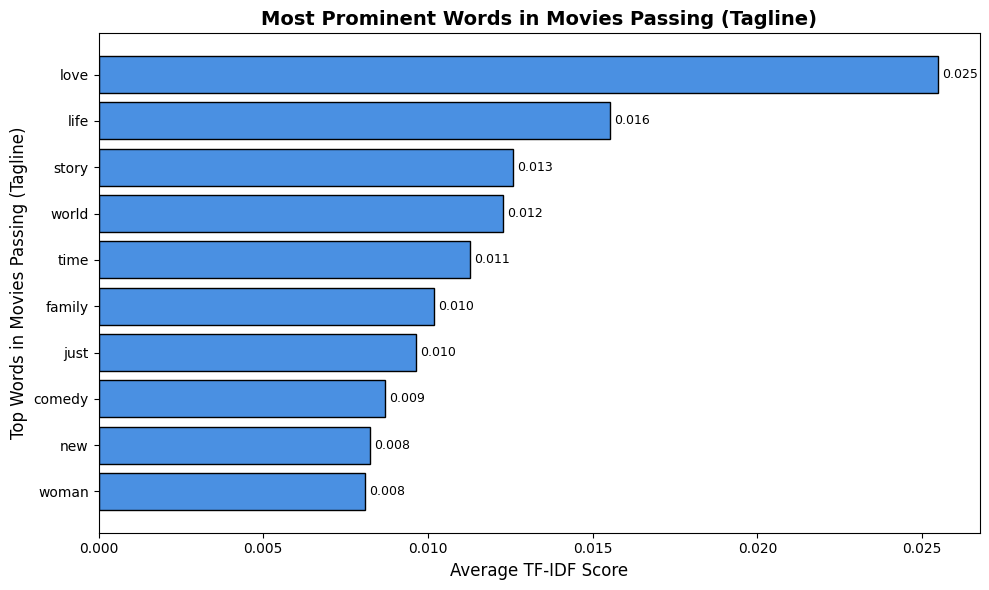

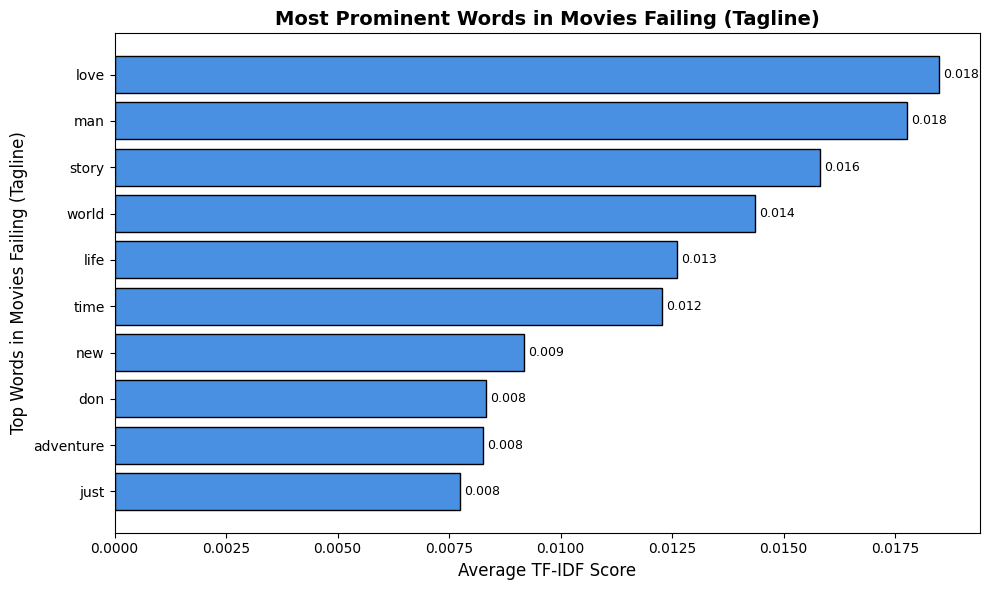

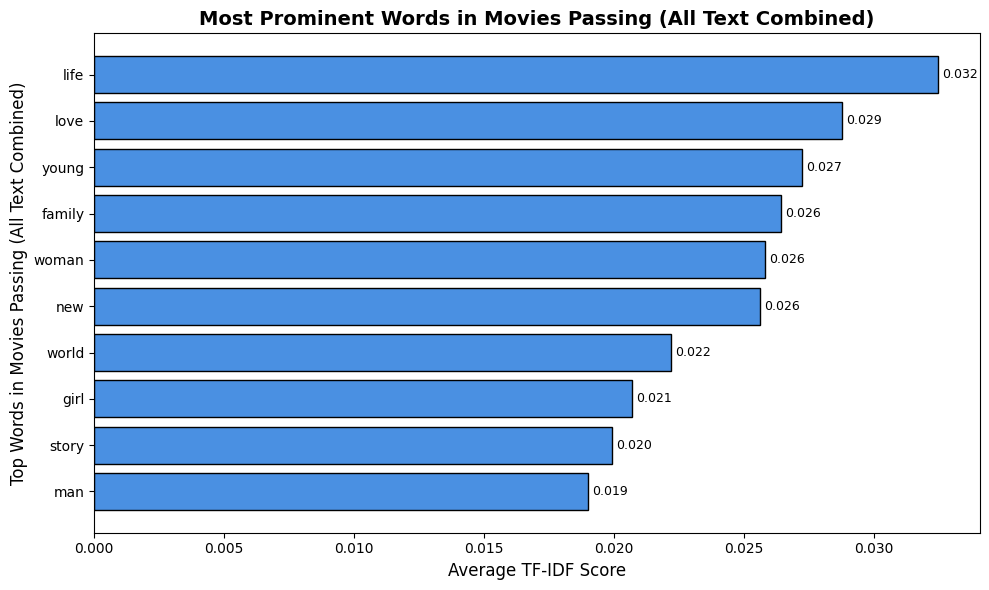

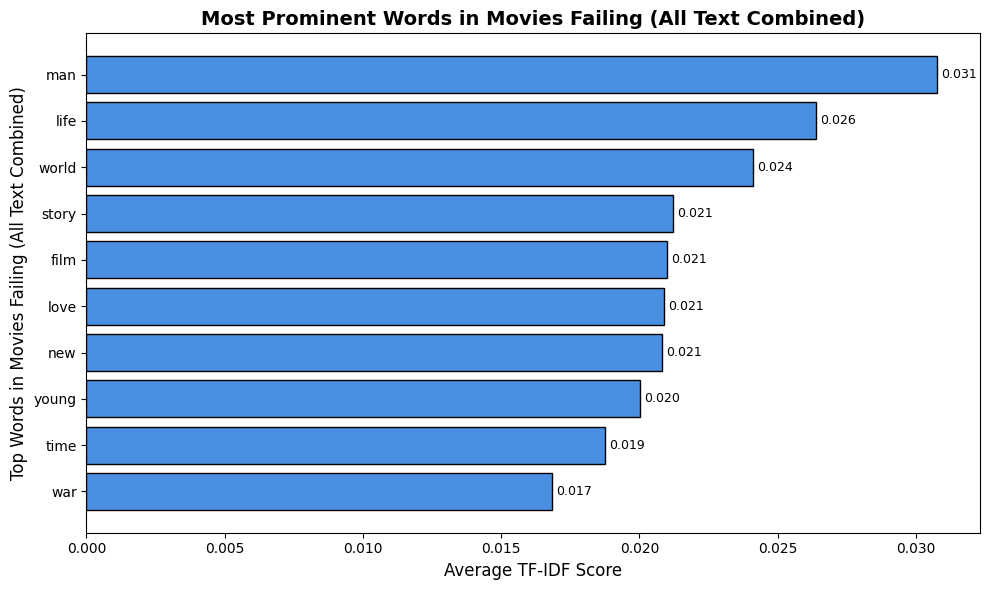

In [9]:
def plot_tfidf(tfidf_df, df, title):
    """
    tfidf_df : TF-IDF matrix for the WHOLE dataset (DataFrame)
    df       : Subset (passing or failing)
    title    : Title for the plot
    """
    viewed_tfidf = tfidf_df.loc[df.index]

    mean_tfidf = viewed_tfidf.mean().sort_values(ascending=False)
    top_words = mean_tfidf.head(10)

    plt.figure(figsize=(10, 6))
    bars = plt.barh(
        top_words.index[::-1],
        top_words.values[::-1],
        color="#4a90e2",
        edgecolor="black"
    )

    plt.xlabel("Average TF-IDF Score", fontsize=12)
    plt.ylabel(f"Top Words in {title}", fontsize=12)
    plt.title(f"Most Prominent Words in {title}", fontsize=14, fontweight='bold')
    plt.tight_layout()

    plt.bar_label(bars, fmt='%.3f', fontsize=9, padding=3)
    save_name = f"./figures/{title.lower().replace(' ', '_')}.png"
    plt.savefig(save_name, dpi=300, bbox_inches="tight")
    plt.show()


movies_metadata = pd.read_parquet('../datasets/movies_metadata.parquet')
bechdel_ratings = pd.read_parquet('../datasets/bechdel_ratings.parquet')

movies = movies_metadata.merge(
    bechdel_ratings,
    on='imdb_id',
    how='inner',
    suffixes=('', '_y')
)

passing_movies = movies[movies['bechdel_rating'] >= 3]
failing_movies = movies[movies['bechdel_rating'] < 3]



def tfidf_full(df, feature):
    text = df[feature].astype(str).fillna("")
    vect = TfidfVectorizer(stop_words='english', max_features=500)
    matrix = vect.fit_transform(text)

    return pd.DataFrame(
        matrix.toarray(),
        index=df.index,
        columns=vect.get_feature_names_out()
    )

def tfidf_all(df):
    combined_text = (
        df["title"].astype(str).fillna("") + " " +
        df["overview"].astype(str).fillna("") + " " +
        df["tagline"].astype(str).fillna("")
    )

    vect = TfidfVectorizer(stop_words='english', max_features=800)
    matrix = vect.fit_transform(combined_text)

    return pd.DataFrame(
        matrix.toarray(),
        index=df.index,
        columns=vect.get_feature_names_out()
    )

overview_tfidf = tfidf_full(movies, "overview")
title_tfidf = tfidf_full(movies, "title")
tagline_tfidf = tfidf_full(movies, "tagline")

combined_tfidf = tfidf_all(movies)

# plot
plot_tfidf(overview_tfidf, passing_movies, "Movies Passing (Overview)")
plot_tfidf(overview_tfidf, failing_movies, "Movies Failing (Overview)")

plot_tfidf(title_tfidf, passing_movies, "Movies Passing (Title)")
plot_tfidf(title_tfidf, failing_movies, "Movies Failing (Title)")

plot_tfidf(tagline_tfidf, passing_movies, "Movies Passing (Tagline)")
plot_tfidf(tagline_tfidf, failing_movies, "Movies Failing (Tagline)")

plot_tfidf(combined_tfidf, passing_movies, "Movies Passing (All Text Combined)")
plot_tfidf(combined_tfidf, failing_movies, "Movies Failing (All Text Combined)")


Summary stats of passing movies
mean: 3.2492940652732845
median: 3.325911875250389
mode: 3.5
std deviation: 0.5242898415372206
 
Summary stats of failing movies
mean: 3.308254439030753
median: 3.375
mode: 3.0
std deviation: 0.5340383804647878


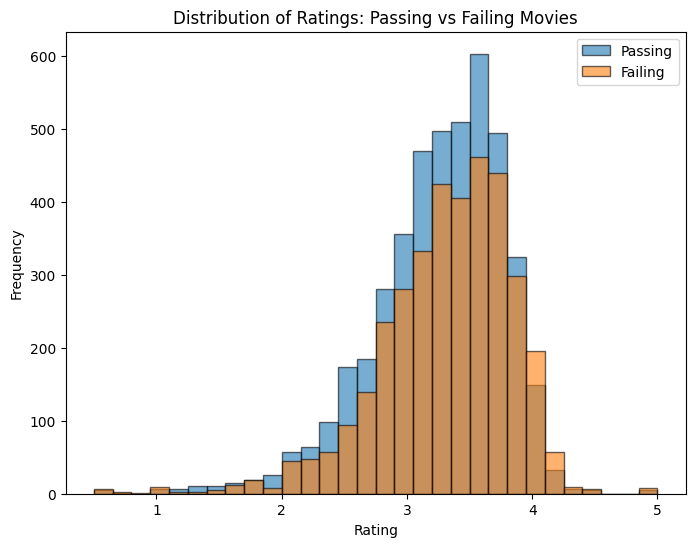

In [5]:
ratings_df = pd.read_parquet('../datasets/avg_ratings.parquet')

df['imdb_id'] = df['imdb_id'].astype(str)
ratings_df['imdb_id'] = ratings_df['imdb_id'].astype(str).str.zfill(7)

movies_w_ratings = ratings_df.merge(df[["imdb_id", "bechdel_rating"]], on="imdb_id", how="left")

passing_movies = movies_w_ratings[movies_w_ratings['bechdel_rating'] >= 3]
failing_movies = movies_w_ratings[movies_w_ratings['bechdel_rating'] < 3]

print("Summary stats of passing movies")
print("mean:", np.mean(passing_movies["rating"]))
print("median:", np.median(passing_movies["rating"]))
print("mode:", passing_movies["rating"].mode()[0])
print("std deviation:", np.std(passing_movies["rating"]))

print(" ")
print("Summary stats of failing movies")
print("mean:", np.mean(failing_movies["rating"]))
print("median:", np.median(failing_movies["rating"]))
print("mode:", failing_movies["rating"].mode()[0])
print("std deviation:", np.std(failing_movies["rating"]))

plt.figure(figsize=(8,6))

plt.hist(passing_movies['rating'], bins=30, alpha=0.6, edgecolor='black', label='Passing')
plt.hist(failing_movies['rating'], bins=30, alpha=0.6, edgecolor='black', label='Failing')

plt.title('Distribution of Ratings: Passing vs Failing Movies')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.legend()
#plt.savefig(f"./figures/ratings_distribution.png", dpi=300, bbox_inches="tight")
plt.show()



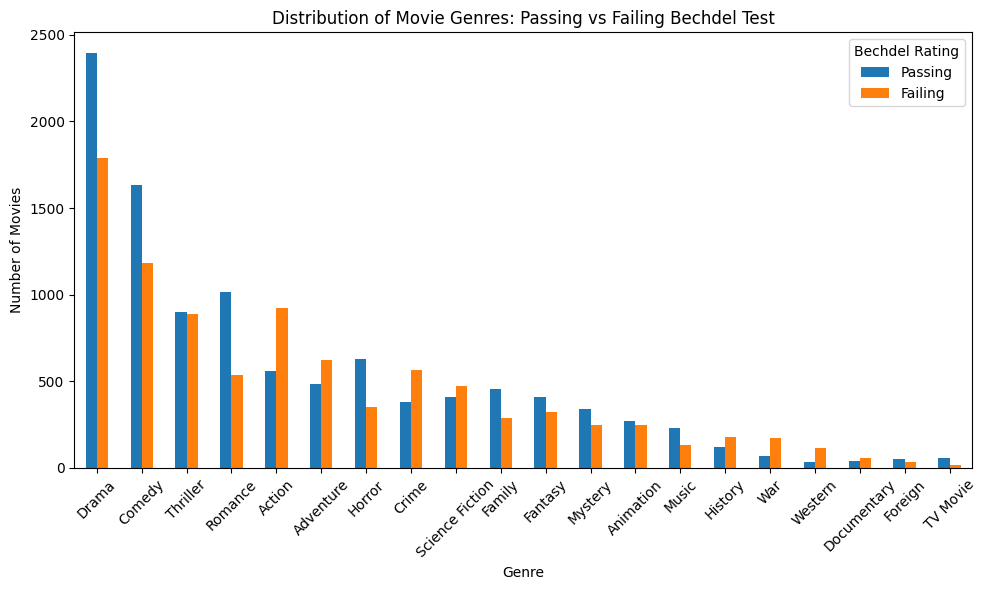

In [6]:
genres_df = pd.read_parquet('../datasets/genres.parquet')

genres_df["imdb_id"] = genres_df["imdb_id"].astype(str).str.replace("^tt", "", regex=True).str.strip()

df['imdb_id'] = df['imdb_id'].astype(str)
genres_df['imdb_id'] = genres_df['imdb_id'].astype(str).str.zfill(7)

movies_w_genres = genres_df.merge(df[["imdb_id", "bechdel_rating"]], on="imdb_id", how="left")

passing_movies_genres = movies_w_genres[movies_w_genres['bechdel_rating'] >= 3]
failing_movies_genres = movies_w_genres[movies_w_genres['bechdel_rating'] < 3]


passing_counts = passing_movies_genres['genre'].value_counts()
failing_counts = failing_movies_genres['genre'].value_counts()


genre_df = pd.DataFrame({
    'Passing': passing_counts,
    'Failing': failing_counts
})

genre_df = genre_df.loc[genre_df.sum(axis=1).sort_values(ascending=False).index]


genre_df.plot(kind='bar', figsize=(10, 6))

plt.title('Distribution of Movie Genres: Passing vs Failing Bechdel Test')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.legend(title='Bechdel Rating')
plt.tight_layout()
#plt.savefig(f"./figures/genres_distribution.png", dpi=300, bbox_inches="tight")
plt.show()



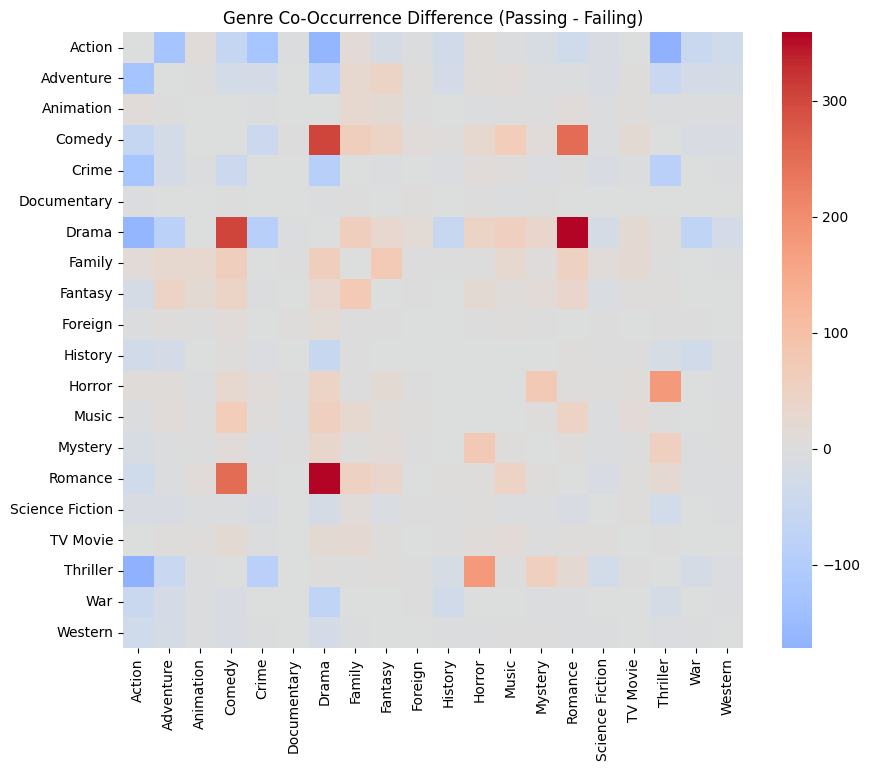

In [7]:
def make_co_matrix(df):
    movies_grouped = df.groupby('imdb_id')['genre'].apply(set)
    genres = sorted(df['genre'].unique())
    co_matrix = pd.DataFrame(0, index=genres, columns=genres)
    for genre_set in movies_grouped:
        for g1, g2 in combinations(genre_set, 2):
            co_matrix.loc[g1, g2] += 1
            co_matrix.loc[g2, g1] += 1
    return co_matrix

passing = movies_w_genres[movies_w_genres['bechdel_rating'] >= 3]
failing = movies_w_genres[movies_w_genres['bechdel_rating'] < 3]

co_pass = make_co_matrix(passing)
co_fail = make_co_matrix(failing)

diff_matrix = co_pass - co_fail

plt.figure(figsize=(10,8))
sns.heatmap(diff_matrix, cmap='coolwarm', center=0)
plt.title('Genre Co-Occurrence Difference (Passing - Failing)')
#plt.savefig(f"./figures/genres_heatmap.png", dpi=300, bbox_inches="tight")
plt.show()

In [8]:
crew = pd.read_parquet('../datasets/crew.parquet')

crew["total_crew"] = crew.groupby("title")["title"].transform("count")

crew["gender_label"] = crew["gender"].map({
    0: "unknown",
    1: "female",
    2: "male"
})

#data cleaning - getting the gender of unknown crew 

d = gender.Detector()
crew.loc[
    crew["gender_label"] == "unknown",
    "gender_label"
] = crew.loc[
    crew["gender_label"] == "unknown",
    "name"
].apply(lambda x: d.get_gender(x.split()[0]))

#only keeping crew with confident gender classifications
crew = crew[(crew["gender_label"] == "male") | (crew["gender_label"] == "female")]
#print(crew[["name", "gender", "gender_label"]].head(50))

crew["total_females"] = crew.groupby("title")["gender_label"].transform(lambda x: (x == "female").sum())
crew["female_ratio"] = crew["total_females"]/crew["total_crew"]

#crew[["imdb_id", "female_ratio"]].drop_duplicates()

ratio_df = crew[["imdb_id", "female_ratio"]].drop_duplicates()
ratio_df = ratio_df[["imdb_id","female_ratio"]]


df['imdb_id'] = df['imdb_id'].astype(str)
ratio_df['imdb_id'] = ratio_df['imdb_id'].astype(str).str.zfill(7)
movies_w_crew = ratio_df.merge(df[["imdb_id", "bechdel_rating"]], on="imdb_id", how="left")

passing = movies_w_crew[movies_w_crew['bechdel_rating'] >= 3]
failing = movies_w_crew[movies_w_crew['bechdel_rating'] < 3]



print("passing")
print(passing["female_ratio"].describe())

print("failing")
print(failing["female_ratio"].describe())




passing
count    1042.000000
mean        0.151263
std         0.172109
min         0.000000
25%         0.000000
50%         0.121217
75%         0.225276
max         1.000000
Name: female_ratio, dtype: float64
failing
count    885.000000
mean       0.144209
std        0.153649
min        0.000000
25%        0.000000
50%        0.125000
75%        0.232558
max        1.000000
Name: female_ratio, dtype: float64


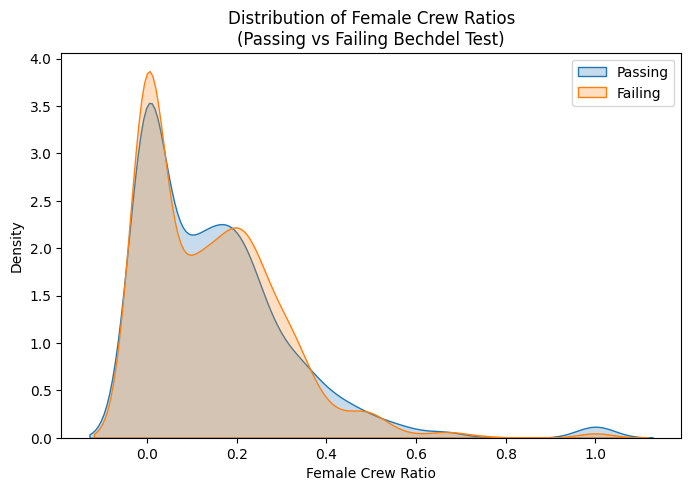

In [9]:
plt.figure(figsize=(8,5))
sns.kdeplot(passing["female_ratio"], label="Passing", fill=True)
sns.kdeplot(failing["female_ratio"], label="Failing", fill=True)
plt.title("Distribution of Female Crew Ratios\n(Passing vs Failing Bechdel Test)")
plt.xlabel("Female Crew Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()

In [10]:
cast = pd.read_parquet('../datasets/cast.parquet')

cast["total_cast"] = cast.groupby("title")["title"].transform("count")

cast["gender_label"] = cast["gender"].map({
    0: "unknown",
    1: "female",
    2: "male"
})

#data cleaning - getting the gender of unknown cast

d = gender.Detector()
cast.loc[
    cast["gender_label"] == "unknown",
    "gender_label"
] = cast.loc[
    cast["gender_label"] == "unknown",
    "name"
].apply(lambda x: d.get_gender(x.split()[0]))

#only keeping cast with confident gender classifications
cast = cast[(cast["gender_label"] == "male") | (cast["gender_label"] == "female")]


cast["total_females"] = cast.groupby("title")["gender_label"].transform(lambda x: (x == "female").sum())
cast["female_ratio"] = cast["total_females"]/cast["total_cast"]

#cast[["imdb_id", "female_ratio"]].drop_duplicates()

ratio_df = cast[["imdb_id", "female_ratio"]].drop_duplicates()
ratio_df = ratio_df[["imdb_id","female_ratio"]]


df['imdb_id'] = df['imdb_id'].astype(str)
ratio_df['imdb_id'] = ratio_df['imdb_id'].astype(str).str.zfill(7)
movies_w_cast = ratio_df.merge(df[["imdb_id", "bechdel_rating"]], on="imdb_id", how="left")

passing = movies_w_cast[movies_w_cast['bechdel_rating'] >= 3]
failing = movies_w_cast[movies_w_cast['bechdel_rating'] < 3]



print("passing")
print(passing["female_ratio"].describe())

print("failing")
print(failing["female_ratio"].describe())


passing
count    1044.000000
mean        0.294924
std         0.164908
min         0.000000
25%         0.176471
50%         0.285714
75%         0.400000
max         1.000000
Name: female_ratio, dtype: float64
failing
count    880.000000
mean       0.294659
std        0.168408
min        0.000000
25%        0.181818
50%        0.285714
75%        0.384615
max        1.000000
Name: female_ratio, dtype: float64


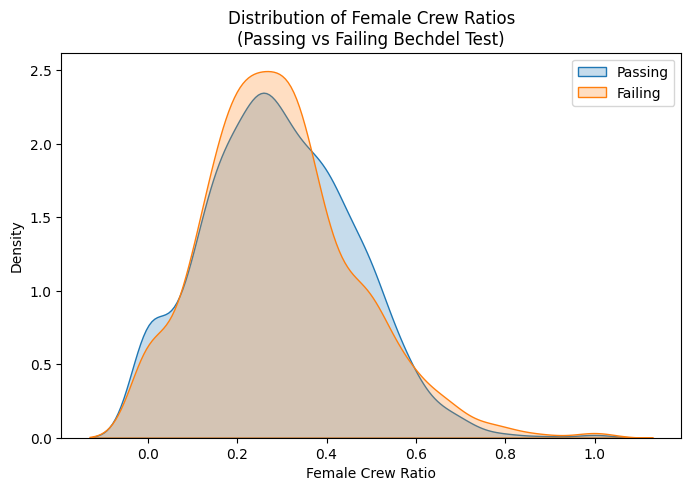

In [11]:
plt.figure(figsize=(8,5))
sns.kdeplot(passing["female_ratio"], label="Passing", fill=True)
sns.kdeplot(failing["female_ratio"], label="Failing", fill=True)
plt.title("Distribution of Female Crew Ratios\n(Passing vs Failing Bechdel Test)")
plt.xlabel("Female Crew Ratio")
plt.ylabel("Density")
plt.legend()
plt.show()

                  name         job  pass_rate  num_movies
3723       Louis Malle    Director   0.333333           3
3405    Katinka Faragó    Producer   0.333333           3
4104    Michael Balcon    Producer   0.333333           3
3979   Martin Scorsese    Producer   0.333333           3
3962    Martin Bregman    Producer   0.333333           3
2880      Jeremy Leven  Screenplay   0.333333           3
1997        G.W. Pabst    Director   0.333333           3
3511        King Vidor    Director   0.333333           3
6233    Victor Saville    Producer   0.333333           3
1034  Christian Zübert    Director   0.333333           3
                name         job  pass_rate  num_movies
52    Aki Kaurismäki    Director        0.0           3
4589    Orson Welles  Screenplay        0.0           4
4587    Orson Welles    Director        0.0           4
4507    Nicolas Roeg    Director        0.0           4
4487       Nick Park    Director        0.0           3
4471    Nicholas Ray    Di

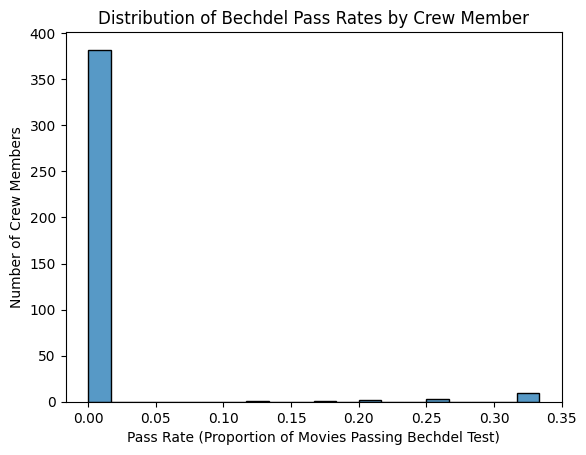

In [12]:
key_roles = ["Director", "Writer", "Producer", "Executive Producer", "Associative Producer", "Screenplay", "Original Story"]

#filter df to only have those jobs
crew["imdb_id"] = crew['imdb_id'].astype(str)
crew_key = crew[crew["job"].isin(key_roles)].copy()

crew_key["imdb_id"] = crew_key["imdb_id"].astype(str)

important_crew = crew_key.merge(
    movies_w_crew[["imdb_id", "bechdel_rating"]],
    on="imdb_id",
    how="left"
)

important_crew["passes_bechdel"] = important_crew["bechdel_rating"] >= 3

person_stats = (
    important_crew.groupby(["name", "job"])["passes_bechdel"]
    .agg(["mean", "count"])
    .reset_index()
    .rename(columns={"mean": "pass_rate", "count": "num_movies"})
)

#filter for those who worked on more than 2 movies
person_stats = person_stats[person_stats["num_movies"] >= 3]

print(person_stats.sort_values("pass_rate", ascending=False).head(10))  
print(person_stats.sort_values("pass_rate", ascending=True).head(10))   

sns.histplot(person_stats["pass_rate"], bins=20)
plt.title("Distribution of Bechdel Pass Rates by Crew Member")
plt.xlabel("Pass Rate (Proportion of Movies Passing Bechdel Test)")
plt.ylabel("Number of Crew Members")
plt.show()

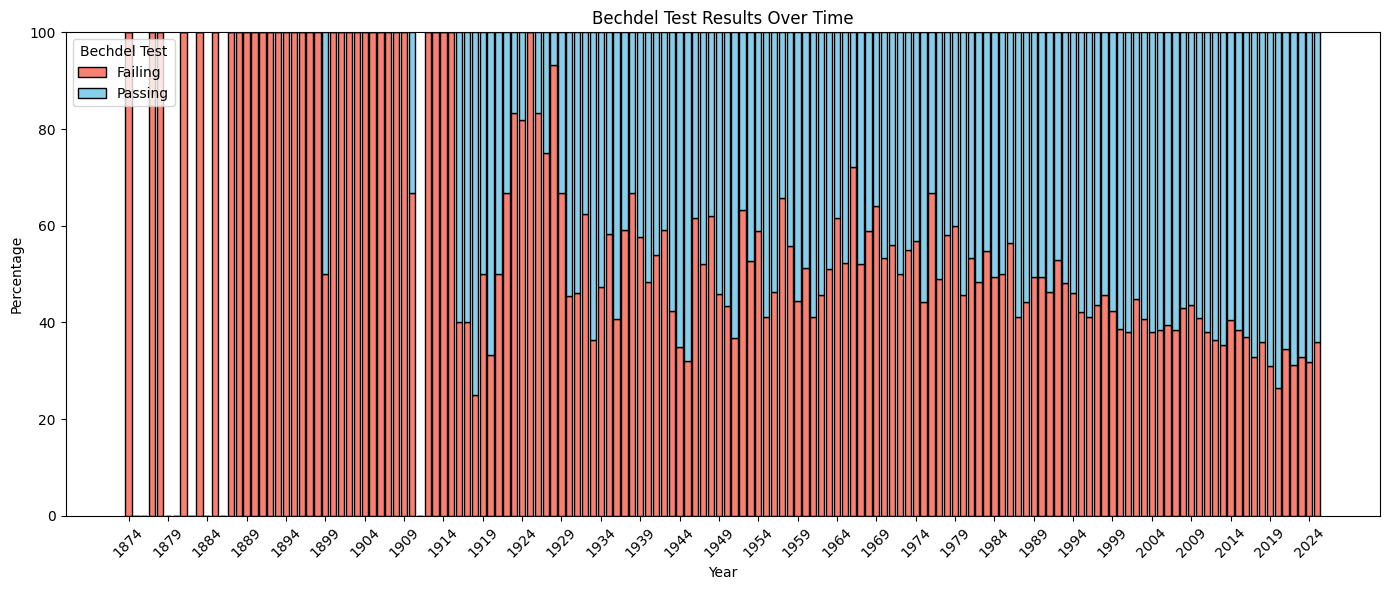

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

bech_ratings = pd.read_parquet('../datasets/bechdel_ratings.parquet')

# Count passing/failing per year
counts = bech_ratings.groupby(['year', bech_ratings['bechdel_rating'] >= 3]).size().unstack(fill_value=0)
counts.columns = ['Failing', 'Passing']

# reindex
min_year = counts.index.min()
max_year = counts.index.max()
all_years = np.arange(min_year, max_year + 1)
counts = counts.reindex(all_years, fill_value=0)

# Compute percentages per year
percentages = counts.div(counts.sum(axis=1).replace(0, 1), axis=0) * 100

# Plot stacked bars
years = percentages.index.values
passing_pct = percentages['Passing'].values
failing_pct = percentages['Failing'].values

plt.figure(figsize=(14,6))
plt.bar(years, failing_pct, color='salmon', edgecolor='black', label='Failing')
plt.bar(years, passing_pct, bottom=failing_pct, color='skyblue', edgecolor='black', label='Passing')

plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Bechdel Test Results Over Time')
plt.legend(title='Bechdel Test')

# make x ticks every 5 years
plt.xticks(years[::5], rotation=45)
plt.tight_layout()
plt.savefig("./figures/bechdel_year_released.png")
plt.show()

plt.hist(bech_ratings['bechdel_rating'], bins=20, alpha=0.6, edgecolor='black', label='Passing')

(array([1158.,    0.,    0.,    0.,    0.,    0., 2276.,    0.,    0.,
           0.,    0.,    0.,    0., 1089.,    0.,    0.,    0.,    0.,
           0., 6039.]),
 array([0.  , 0.15, 0.3 , 0.45, 0.6 , 0.75, 0.9 , 1.05, 1.2 , 1.35, 1.5 ,
        1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  ]),
 <BarContainer object of 20 artists>)

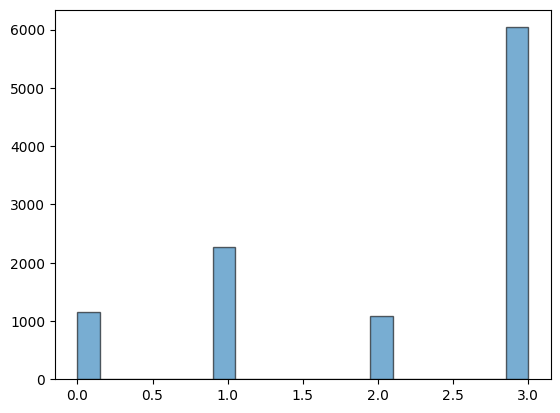